In [1]:
from prophet import Prophet
from neuralprophet import NeuralProphet
import xgboost as xgb

import sys, os, yaml, ta
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import yfinance as yf
from dateutil.relativedelta import relativedelta

from stock_forecast_module import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

/Users/truongnguyen/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load inputs from inputs.yml
with open('inputs.yml', 'r') as file:
    inputs = yaml.safe_load(file)

# Access specific inputs
start_dt = inputs['params']['start_dt']
split_dt = inputs['params']['split_dt']
real_fc_start_dt = datetime.today().date().strftime('%Y-%m-%d') # inputs['params']['real_fc_start_dt']
real_fc_end_dt = inputs['params']['real_fc_end_dt']
stock_sticker = inputs['params']['stock_sticker']

print(f"Stock sticker: {stock_sticker}")
print(f"Start date: {start_dt}")
print(f"Split date: {split_dt}")
print(f"Real forecast start date: {real_fc_start_dt}")
print(f"Real forecast end date: {real_fc_end_dt}")

Stock sticker: TSLA
Start date: 2018-01-01
Split date: 2025-01-01
Real forecast start date: 2025-05-02
Real forecast end date: 2025-08-15


In [3]:
# Download SP500, NASDAQ, and VIX data
today_date = datetime.today().date()

sp500_data = yf.download('^GSPC',   start=start_dt, end=today_date.strftime('%Y-%m-%d'))
nasdaq_data = yf.download('^IXIC',  start=start_dt, end=today_date.strftime('%Y-%m-%d'))
vix_data = yf.download('^VIX',      start=start_dt, end=today_date.strftime('%Y-%m-%d'))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Download AAPL, NVDA, and MSFT stock price data
aapl_data = yf.download('AAPL', start=start_dt, end=today_date.strftime('%Y-%m-%d'))
nvda_data = yf.download('NVDA', start=start_dt, end=today_date.strftime('%Y-%m-%d'))
msft_data = yf.download('MSFT', start=start_dt, end=today_date.strftime('%Y-%m-%d'))

display(aapl_data.head())
display(aapl_data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479847,40.489249,39.774869,39.986364,102223600
2018-01-03,40.472790,41.017975,40.409344,40.543288,118071600
2018-01-04,40.660786,40.764183,40.437543,40.545638,89738400
2018-01-05,41.123722,41.210668,40.665487,40.757134,94640000
2018-01-08,40.970974,41.267063,40.872274,40.970974,82271200


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-25,209.279999,209.750000,206.199997,206.369995,38222300
2025-04-28,210.139999,211.500000,207.460007,210.000000,38743100
2025-04-29,211.210007,212.240005,208.369995,208.690002,36827600
2025-04-30,212.500000,213.580002,206.669998,209.300003,52286500
2025-05-01,213.320007,214.559998,208.899994,209.080002,57365700


In [5]:
stock_data, stocks_indicator_features = import_stock_data(stock_sticker, start_dt)
display(stock_data.head())
display(stock_data.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,RSI,MACD,EMA_9_of_MACD,BB_High,BB_Low,SMA_20,MA_30
0,2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000,49.683740,0.015227,0.158966,23.210638,19.928161,21.569400,21.328555
1,2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500,47.306395,-0.007190,0.125734,23.166286,20.052848,21.609567,21.333444
2,2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500,45.429338,-0.038659,0.092856,23.104457,20.187476,21.645967,21.346511
3,2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000,47.113517,-0.052449,0.063795,23.095450,20.218616,21.657033,21.343778
4,2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000,60.422129,0.042803,0.059596,23.153299,20.328568,21.740933,21.396689


,Date,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,RSI,MACD,EMA_9_of_MACD,BB_High,BB_Low,SMA_20,MA_30
1838,2025-04-25,284.950012,286.850006,259.630005,261.690002,167560700,58.134886,-3.939662,-8.392631,286.609039,219.665963,253.137501,253.620001
1839,2025-04-28,285.880005,294.859985,272.420013,288.980011,151731800,58.374009,-1.107777,-6.935661,290.421499,218.086504,254.254002,254.816668
1840,2025-04-29,292.029999,293.320007,279.470001,285.500000,108906600,60.001041,1.614158,-5.225697,295.619975,216.175027,255.897501,256.617335
1841,2025-04-30,282.160004,284.450012,270.779999,279.899994,128961100,56.204160,2.940983,-3.592361,297.599311,215.565693,256.582502,258.512335
1842,2025-05-01,280.519989,290.869995,279.809998,280.010010,99659000,55.574853,3.816176,-2.110654,297.212085,215.728916,256.470501,260.001001


In [6]:
### DATA PREPROCESSING & FEATURE ENGINEERING ###

df, exo_vars = preprocess_data(stock_data, 
                               stocks_additional_features=stocks_indicator_features, 
                               sticker=stock_sticker)

# get stock market data (SP500, NASDAQ, VIX)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')
# add market data columns to exogeneous variables
df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols)

# get tech stocks data (AAPL, NVDA, MSFT)
df_tech = clean_tech_stocks_data(aapl_data, nvda_data, msft_data)
df = df.merge(df_tech, on='ds', how='left')
# add market data columns to exogeneous variables
df_tech_cols = df_tech.columns.tolist()
df_tech_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_tech_cols)

# get earnings dates (might be helpfull for training/predictions - Right now, not used)
df_earnings, eps_cols = get_earnings_dates(sticker=stock_sticker)
df = df.merge(df_earnings, on='ds', how='left')

# get federal reserve data
df, exo_vars = get_federal_reserve_data(df, exo_vars, start_date=start_dt)

# get daily news sentiment data
df_news_sentiment, exo_vars = extract_historical_news_sentiment(exo_vars, folder_path="gdelt_news_sentiment")
df = df.merge(df_news_sentiment, on='ds', how='left')

# create train and test sets from overall dataset
df, df_train, df_test = create_train_test_sets(df, split_date=split_dt, start_date=start_dt)

print("using exogeneous features:", exo_vars)



### MODEL TRAINING AND FORECASTING ###

# Train Prophet model
prophet_model = train_prophet_model(df_train, exo_vars)
# Make forecast using Prophet model on training data and compute residuals: r = y - y_hat
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)
# Train XGBoost model on residuals
xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)
# Make predictions using the trained models y_final = y_hat + residuals
# Here, we assume we have future data for exogeneous variables in df_test
df_results = make_predictions(df_residuals, df, df_test, prophet_model, xgb_model, exo_vars, eps_cols, split_date=split_dt)

WARNING - (py.warnings._showwarnmsg) - /Users/truongnguyen/Desktop/U_of_L_MSCS/truongbnguyen88_github_repos/stocks_forecasting/stocks_forecasting/stock_forecast_module.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_lag1'] = df_train['y'].shift(1)

WARNING - (py.warnings._showwarnmsg) - /Users/truongnguyen/Desktop/U_of_L_MSCS/truongbnguyen88_github_repos/stocks_forecasting/stocks_forecasting/stock_forecast_module.py:413: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y_lag2'] = df

using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


16:15:58 - cmdstanpy - INFO - Chain [1] done processing


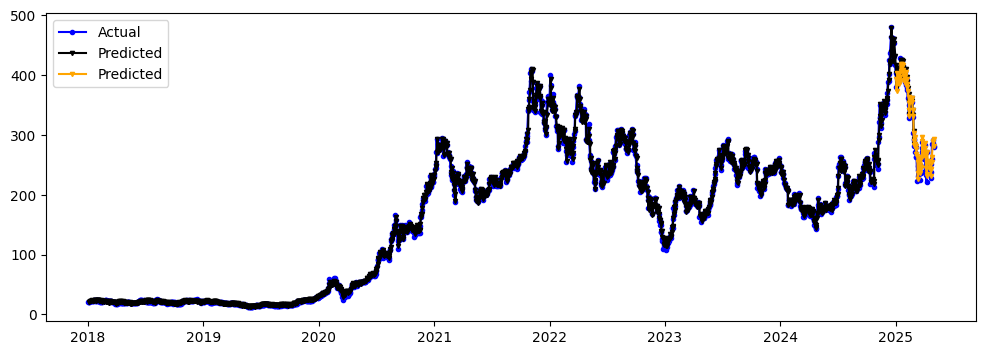

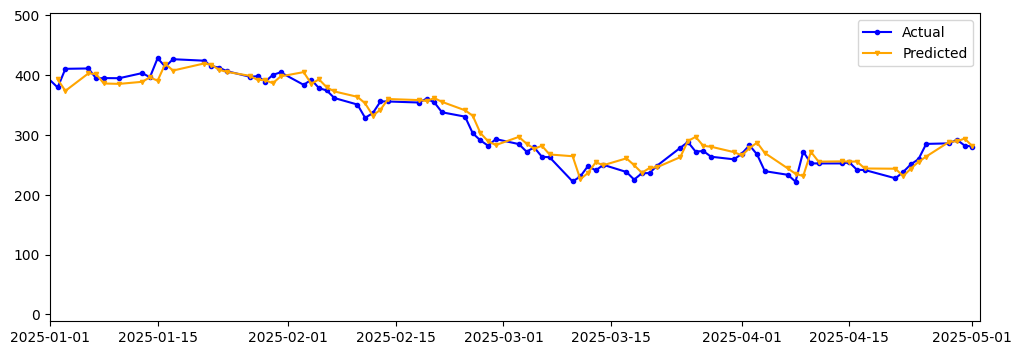

In [7]:
### PLOTTING RESULTS ###

df1 = forecast[forecast['ds'] < '2025-03-01'].copy(deep=True)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df1['ds'],          df1['yhat'],             label='Predicted', color='black',   marker='v', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(df['ds'],           df['y'],              label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df_results['ds'],   df_results['preds'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.xlim(pd.to_datetime(split_dt), pd.to_datetime(today_date))
plt.legend()
plt.show()

In [8]:
# Predict future exogeneous variables at future dates since in practice we don't have them available
# This is a mock way to simulate future exogenous variables
df_exo_vars_forecast = predict_future_exo_vars(df_train, df_test, exo_vars, lag_vars=['y_lag1','y_lag2'])
display(df_exo_vars_forecast.head())
# once we roughly-forecast future exogenous variables, we can use them to predict future stock prices
forecast = predict_with_unk_future_exo_vars(
                            df_exo_vars_forecast, df_train, df_test, 
                            prophet_model, xgb_model, 
                            exo_vars, eps_cols, lag_vars=['y_lag1','y_lag2'],
                            split_date=split_dt
            )

16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing


['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']
high_value


16:16:00 - cmdstanpy - INFO - Chain [1] start processing


low_value


16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing


open_value


16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing


volume_value


16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing


RSI


16:16:02 - cmdstanpy - INFO - Chain [1] start processing


MACD


16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing


BB_High


16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing


BB_Low


16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing


SMA_20


16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing


EMA_9_of_MACD


16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:05 - cmdstanpy - INFO - Chain [1] start processing


MA_30


16:16:05 - cmdstanpy - INFO - Chain [1] done processing
16:16:05 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


16:16:05 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing


vix_close


16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing


aapl_close


16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing


aapl_volume


16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing


nvda_close


16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing


nvda_volume


16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing


msft_close


16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing


msft_volume


16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing


cpi


16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing


unemployment_rate


16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing


interest_rate


16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing


umcsent


16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing


gdp_growth


16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing


mortgage_rate


16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing


SentimentScore


16:16:14 - cmdstanpy - INFO - Chain [1] start processing


y_lag1


16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:15 - cmdstanpy - INFO - Chain [1] start processing


y_lag2


16:16:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,high_value,low_value,open_value,volume_value,RSI,MACD,BB_High,BB_Low,SMA_20,EMA_9_of_MACD,MA_30,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close,aapl_close,aapl_volume,nvda_close,nvda_volume,msft_close,msft_volume,cpi,unemployment_rate,interest_rate,umcsent,gdp_growth,mortgage_rate,SentimentScore,y_lag1,y_lag2,eps_estimate,reported_eps,surprise_pct
0,2018-01-04,24.608066,23.710764,24.078108,83.320025,50.912079,-0.085638,26.354979,21.492210,23.800280,0.030555,24.031455,2627.038173,8.017225,6865.881695,7.610385,14.806172,38.574573,4.839063,5.000379,6.308460,74.166623,3.265162,248.863276,3.709471,1.402364,96.535122,1.697361,4.242838,-1.342433,43.082714,43.644038,NaN,NaN,NaN
1,2018-01-05,24.809728,23.903163,24.262415,83.429139,51.371050,-0.083170,26.340811,21.484244,23.796925,0.030687,24.024556,2631.349636,8.030985,6873.307495,7.614951,14.592971,38.538579,4.852320,4.959833,6.304911,74.285183,3.263855,248.885965,3.696755,1.404877,96.673426,1.746548,4.234341,-1.337268,41.419862,42.551848,NaN,NaN,NaN
2,2018-01-08,25.731128,24.766460,25.141121,81.486126,54.007732,-0.076707,26.408971,21.489400,23.858285,0.030881,24.038074,2652.678420,8.072608,6927.691661,7.624527,13.833554,38.641606,4.812883,4.890800,6.285222,75.085638,3.230943,248.939371,3.666962,1.411900,97.085234,1.904496,4.200775,-1.302754,38.302587,39.174999,NaN,NaN,NaN
3,2018-01-09,26.120983,25.108026,25.504966,81.677122,55.183930,-0.075126,26.471681,21.492214,23.899724,0.030920,24.051700,2661.290527,8.088789,6952.291114,7.626542,13.518675,38.732094,4.789789,4.882312,6.281729,75.483854,3.225610,248.953815,3.655658,1.414472,97.213681,1.958885,4.190980,-1.290238,37.694499,37.372005,NaN,NaN,NaN
4,2018-01-10,26.512278,25.431337,25.859270,82.846179,56.323003,-0.073757,26.558861,21.485742,23.948839,0.030989,24.071112,2669.693964,8.107513,6976.950985,7.629691,13.205532,38.835565,4.774845,4.881128,6.281391,75.907679,3.231551,248.968914,3.641483,1.417177,97.340884,2.011233,4.183222,-1.279457,36.400866,36.975938,NaN,NaN,NaN


Using the following exogeneous variables:  ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


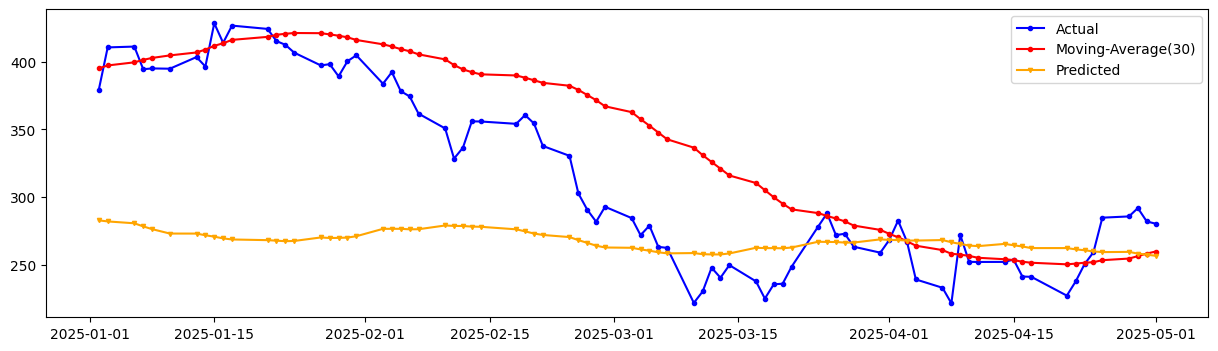

MAPE Score: 3.83%
RMSE Score: 14.76
MAE  Score: 11.27
high_value


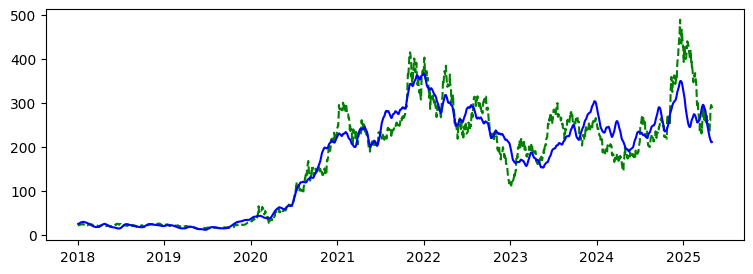

low_value


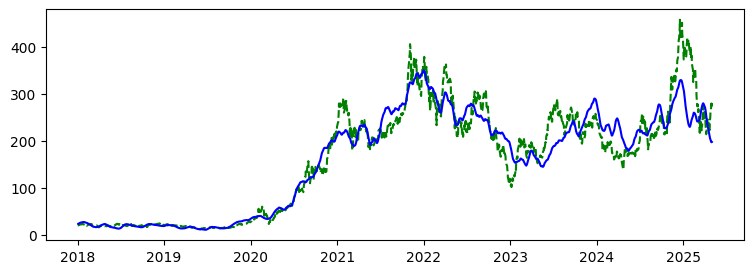

open_value


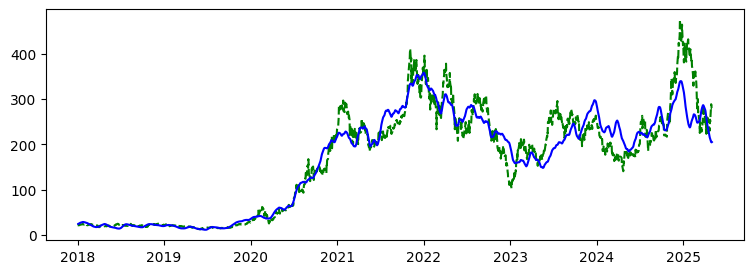

volume_value


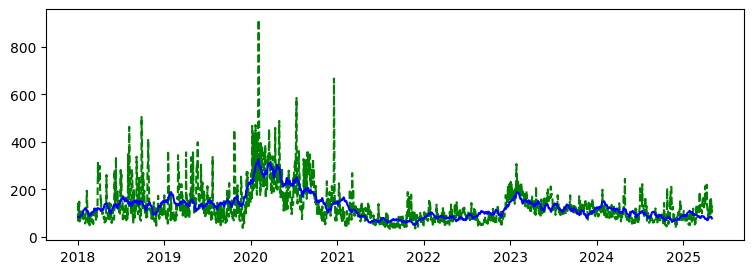

RSI


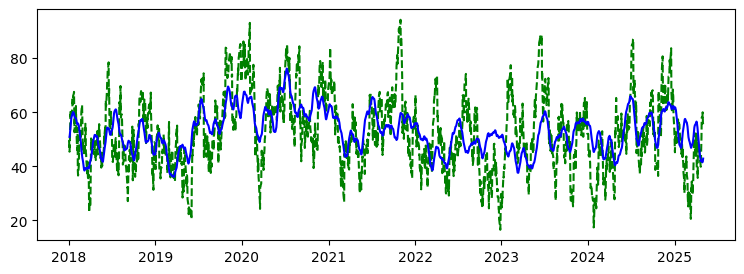

MACD


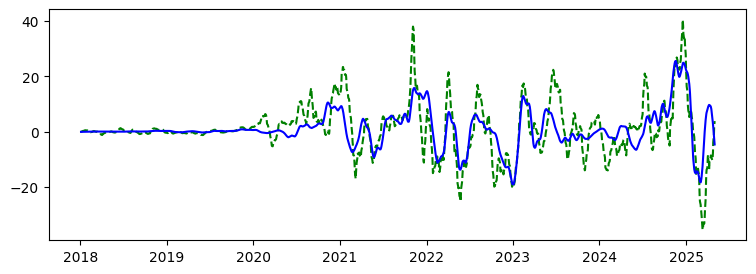

BB_High


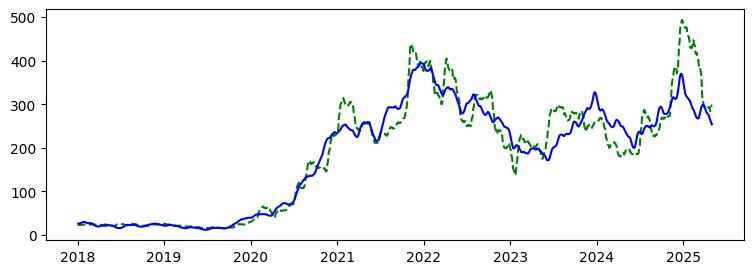

BB_Low


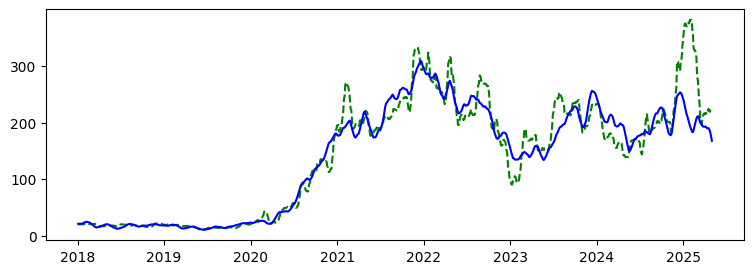

SMA_20


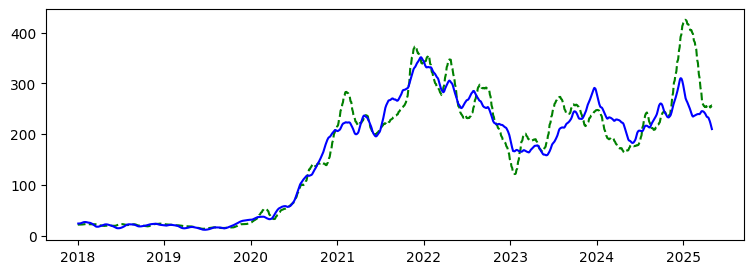

EMA_9_of_MACD


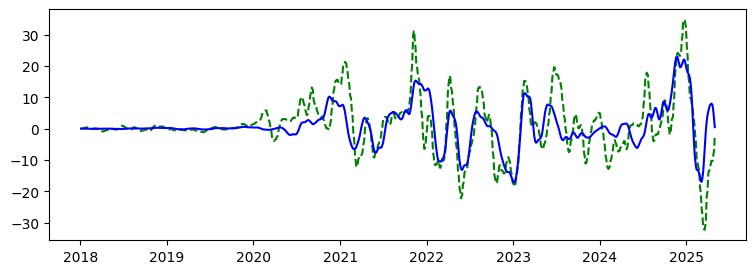

MA_30


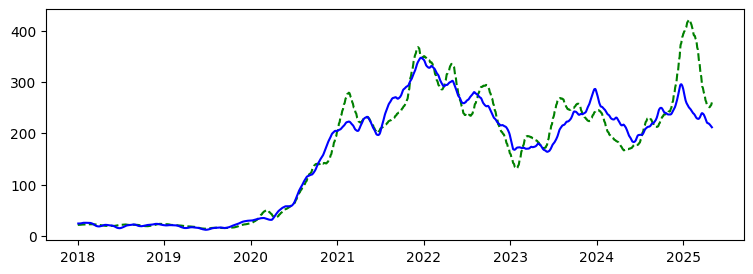

sp500_close


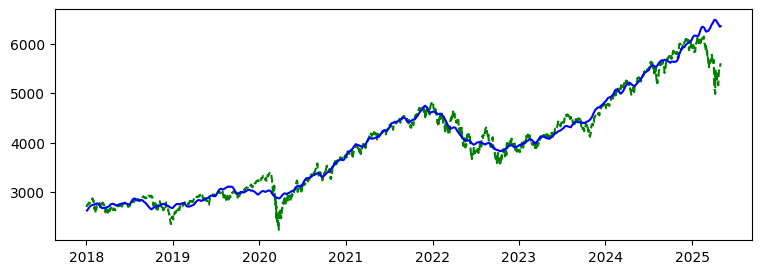

sp500_volume


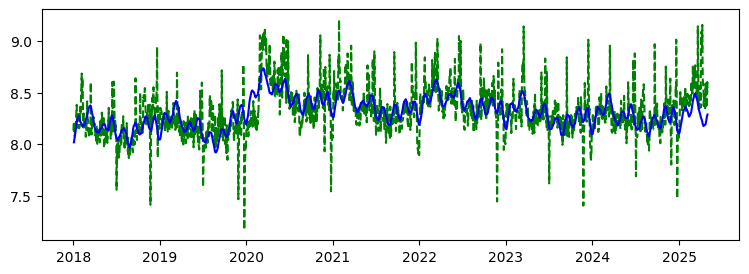

nasdaq_close


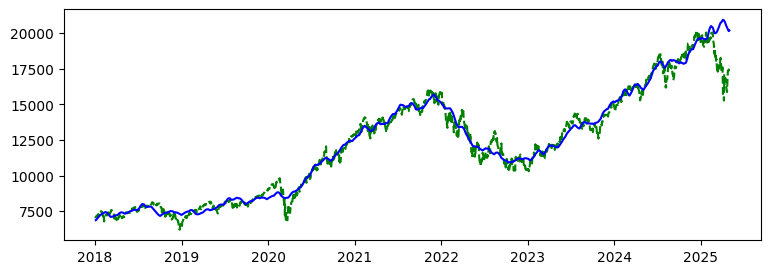

nasdaq_volume


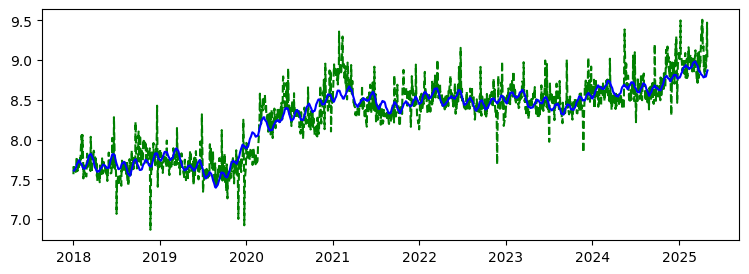

vix_close


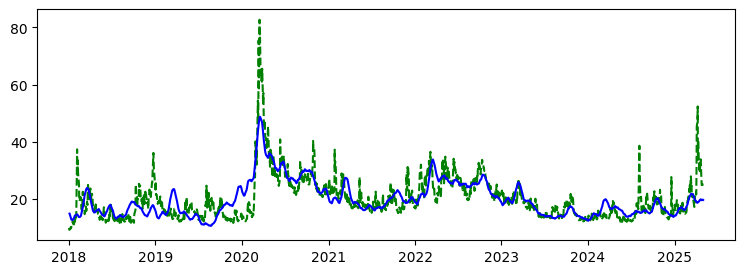

aapl_close


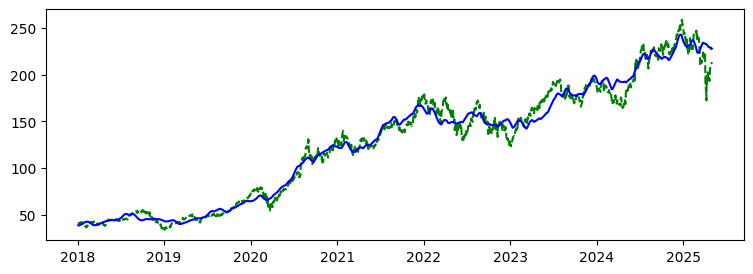

aapl_volume


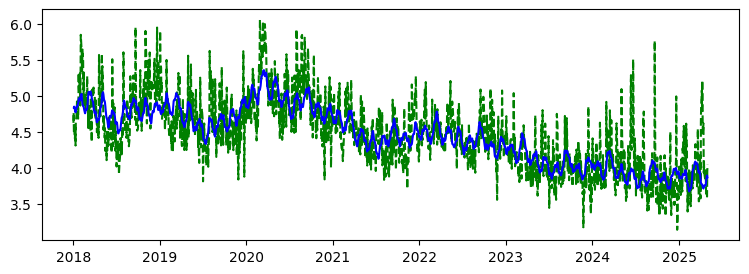

nvda_close


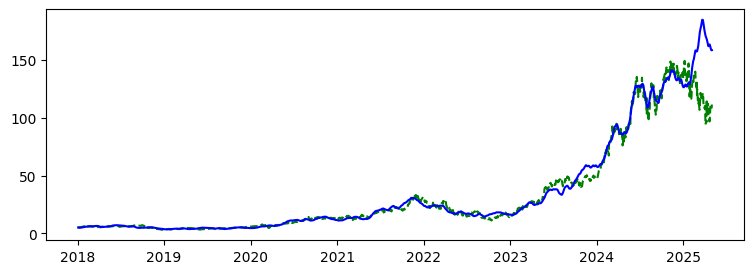

nvda_volume


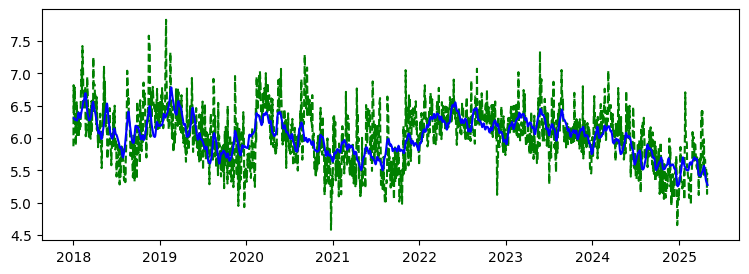

msft_close


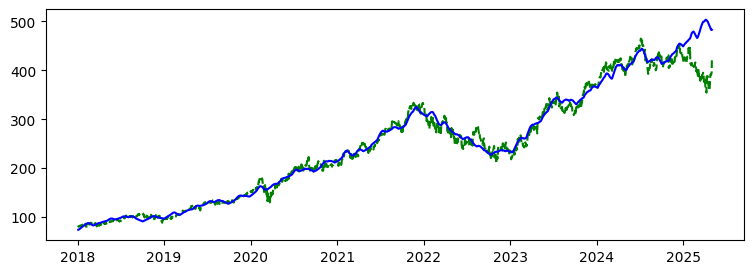

msft_volume


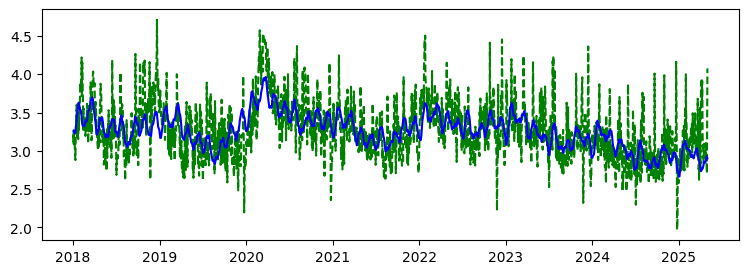

cpi


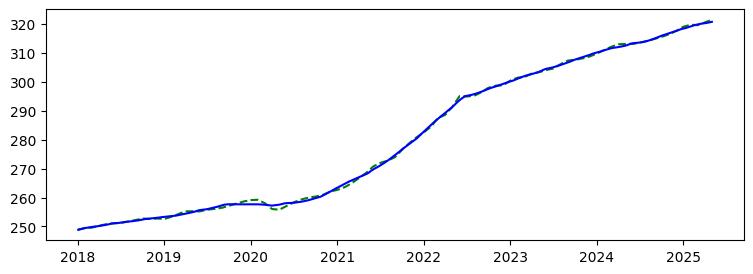

unemployment_rate


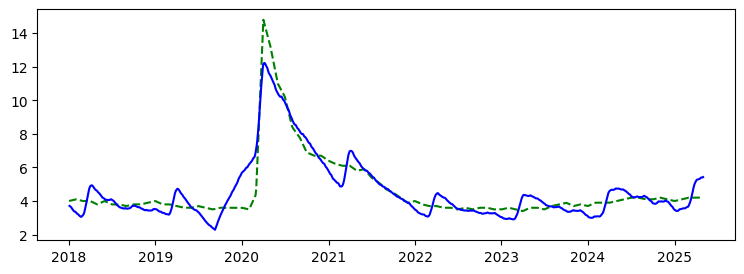

interest_rate


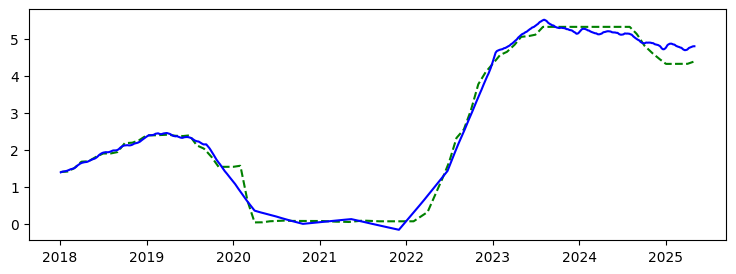

umcsent


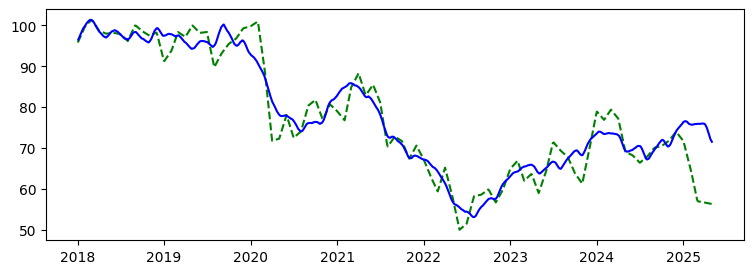

gdp_growth


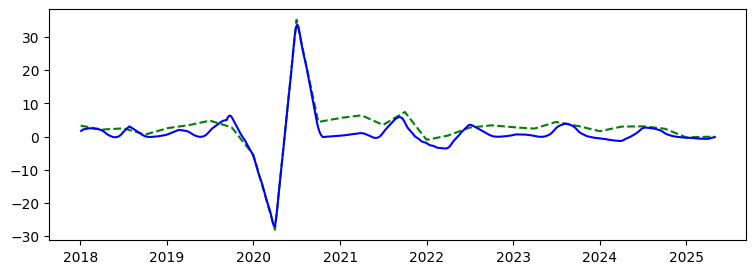

mortgage_rate


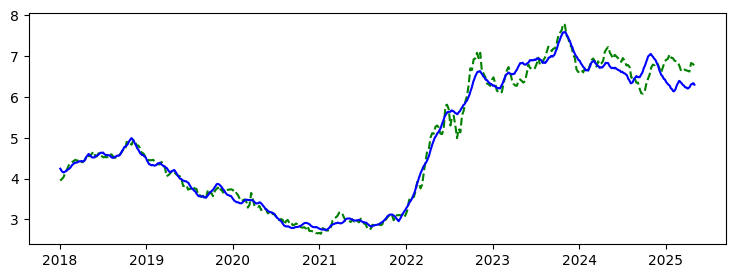

SentimentScore


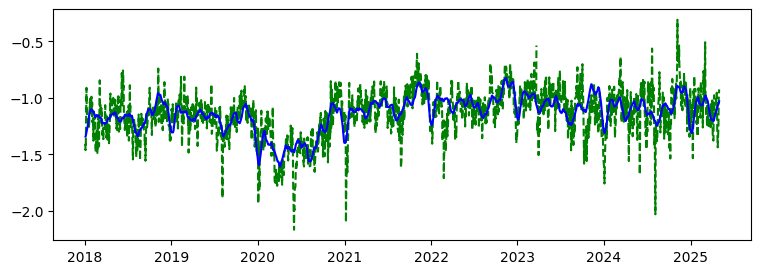

In [9]:
### PLOTTING forecast results with future exogenous variables ###
split_date = split_dt
df1 = forecast[forecast['ds'] >= split_date].copy(deep=True)

df['y_moving_avg'] = df['y'].rolling(window=30).mean()
df2 = df[df['ds'] >= split_date].copy(deep=True)

fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(df2['ds'], df2['y'],     label='Actual',    color='blue',   marker='o', markersize=3)
plt.plot(df2['ds'], df2['y_moving_avg'], label='Moving-Average(30)',    color='red',   marker='o', markersize=3)
plt.plot(df1['ds'], df1['yhat'],  label='Predicted', color='orange', marker='v', markersize=3)
plt.legend()
plt.show()


### Calculate Performance Scores for the test set ###
actual_values = df2['y'].values
predicted_values = df_results['preds'].values

mape_score, rmse_score, mae_score = calculate_performance_scores(actual_values, predicted_values)
print(f"MAPE Score: {mape_score*100.0:.2f}%")
print(f"RMSE Score: {rmse_score:.2f}")
print(f"MAE  Score: {mae_score:.2f}")

# Plot exogenous variables trends
for exo_var_ in exo_vars:
    print(exo_var_)
    fig, ax = plt.subplots(figsize=(9, 3))
    plt.plot(df['ds'], df[exo_var_], label='CPI', color='green', linestyle='--')
    plt.plot(df_exo_vars_forecast['ds'], df_exo_vars_forecast[exo_var_], label='CPI', color='blue', linestyle='-')
    plt.show()

### Make real forecast for real future dates/months

In [11]:
# Now we gonna make real predictions for future unknown dates
df, exo_vars = preprocess_data(stock_data, 
                               stocks_additional_features=stocks_indicator_features, 
                               sticker=stock_sticker)

# get market data (SP500, NASDAQ, VIX)
df_market = clean_market_data(sp500_data, nasdaq_data, vix_data)
df = df.merge(df_market, on='ds', how='left')
# add market data columns to exogeneous variables
df_market_cols = df_market.columns.tolist()
df_market_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_market_cols) 

# get tech stocks data (AAPL, NVDA, MSFT)
df_tech = clean_tech_stocks_data(aapl_data, nvda_data, msft_data)
df = df.merge(df_tech, on='ds', how='left')
# add market data columns to exogeneous variables
df_tech_cols = df_tech.columns.tolist()
df_tech_cols.remove('ds')  # Remove 'ds' from the list of market columns
exo_vars.extend(df_tech_cols)

# get earning dates (might be helpfull for training/predictions - Right now, not used)
df_earnings, eps_cols = get_earnings_dates(sticker=stock_sticker)
df = df.merge(df_earnings, on='ds', how='left')

# get federal reserve data
df, exo_vars = get_federal_reserve_data(df, exo_vars, start_date=start_dt)

# get daily news sentiment data
df_news_sentiment, exo_vars = extract_historical_news_sentiment(exo_vars, folder_path="gdelt_news_sentiment")
df = df.merge(df_news_sentiment, on='ds', how='left')

print("using exogeneous features:", exo_vars)

# create train dataset which basically entire dataset of the stock
df_train = df.copy(deep=True)

# train prophet and xgb models
eps_cols = []
prophet_model = train_prophet_model(df_train, exo_vars)
forecast = make_prophet_forecast(df, prophet_model)
df_residuals = create_residuals(df_train, forecast, exo_vars, eps_cols)
xgb_model = train_xgb_model(df_residuals, exo_vars, eps_cols)

# generate forecast for exogeneous in future dates (beyond today date!)
df_exo_vars_forecast = generate_future_exogeneous_vars_forecasts(
                                df_residuals, 
                                exo_vars, lag_vars=['y_lag1','y_lag2'],
                                start_fc_date=real_fc_start_dt, 
                                end_fc_date=real_fc_end_dt
                        )

# Now we can use the trained models to predict future stock prices beyond today date
# starting from 'real_fc_start_dt' to 'real_fc_end_dt' which can be specified in inputs.yml
df_results, forecast_historical = predict_with_forecasted_exo_vars(
                                        df_exo_vars_forecast,
                                        prophet_model, xgb_model, 
                                        exo_vars, eps_cols, lag_vars=['y_lag1','y_lag2'],
                                        start_fc_dt=real_fc_start_dt,
                                        end_fc_dt=real_fc_end_dt,
                                    )

16:16:49 - cmdstanpy - INFO - Chain [1] start processing


using exogeneous features: ['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


16:16:50 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing


high_value


16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing


low_value


16:16:52 - cmdstanpy - INFO - Chain [1] start processing


open_value


16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start processing


volume_value


16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:53 - cmdstanpy - INFO - Chain [1] done processing
16:16:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


RSI


16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing


MACD


16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing


BB_High


16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing


BB_Low


16:16:56 - cmdstanpy - INFO - Chain [1] done processing
16:16:56 - cmdstanpy - INFO - Chain [1] start processing


SMA_20


16:16:56 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing


EMA_9_of_MACD


16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing


MA_30


16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing


sp500_close


16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing


sp500_volume


16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_close


16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing


nasdaq_volume


16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing


vix_close


16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing


aapl_close


16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing


aapl_volume


16:17:01 - cmdstanpy - INFO - Chain [1] start processing


nvda_close


16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing


nvda_volume


16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing


msft_close


16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing


msft_volume


16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing


cpi


16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing


unemployment_rate


16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing


interest_rate


16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing


umcsent


16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:06 - cmdstanpy - INFO - Chain [1] start processing


gdp_growth


16:17:06 - cmdstanpy - INFO - Chain [1] done processing
16:17:06 - cmdstanpy - INFO - Chain [1] start processing


mortgage_rate


16:17:06 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing


SentimentScore


16:17:07 - cmdstanpy - INFO - Chain [1] start processing


y_lag1


16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing


y_lag2


16:17:08 - cmdstanpy - INFO - Chain [1] done processing


(1990, 32) 2018-01-01 00:00:00 2025-08-15 00:00:00


,ds,high_value,low_value,open_value,volume_value,RSI,MACD,BB_High,BB_Low,SMA_20,EMA_9_of_MACD,MA_30,sp500_close,sp500_volume,nasdaq_close,nasdaq_volume,vix_close,aapl_close,aapl_volume,nvda_close,nvda_volume,msft_close,msft_volume,cpi,unemployment_rate,interest_rate,umcsent,gdp_growth,mortgage_rate,SentimentScore,y_lag1,y_lag2
1985,2025-08-11,337.671281,322.304391,330.012950,62.615194,52.982547,-15.194754,380.167994,262.808877,320.222207,-11.722055,321.498062,6594.393401,8.359325,21478.192978,9.051803,19.439826,270.625167,3.677840,198.149582,5.085164,449.504371,2.830185,322.893387,4.343703,4.197496,57.673094,0.130578,6.053198,-1.162386,320.427856,319.576133
1986,2025-08-12,339.812508,324.643008,332.191327,65.192515,53.286282,-14.779892,380.899529,263.310790,320.838386,-12.164191,321.951126,6607.234798,8.347070,21534.416112,9.041723,19.406638,271.673232,3.667561,200.508189,5.119905,450.066019,2.829102,322.903080,4.352915,4.193136,57.736123,0.125485,6.060833,-1.159020,321.092202,319.225129
1987,2025-08-13,341.412624,326.201043,333.680748,68.732191,53.447601,-14.143548,380.781350,263.787242,321.023251,-12.340951,322.051541,6618.360518,8.337891,21582.834807,9.034392,19.455904,272.700415,3.666229,202.963375,5.155742,450.504634,2.833086,322.914525,4.363080,4.189776,57.804347,0.120346,6.068085,-1.156803,321.283084,320.125348
1988,2025-08-14,342.343668,326.941953,334.416399,72.588497,53.505540,-13.309272,379.896420,264.196605,320.795372,-12.239443,321.814753,6627.559579,8.330517,21623.128274,9.029505,19.583646,273.700431,3.670780,205.512806,5.187041,450.761181,2.838338,322.928214,4.374562,4.186619,57.870411,0.115164,6.073678,-1.155049,322.030748,320.703284
1989,2025-08-15,342.734194,327.119622,334.612172,76.104566,53.543370,-12.313284,378.471829,264.625949,320.312871,-11.895649,321.353120,6635.172939,8.323033,21657.553718,9.025545,19.760099,274.701722,3.676281,208.099087,5.209250,450.853061,2.840197,322.943662,4.387611,4.182780,57.927005,0.109936,6.077112,-1.152762,322.095342,321.622807


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,y_lag1,y_lag1_lower,y_lag1_upper,y_lag2,y_lag2_lower,y_lag2_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1910,2025-08-11,145.658531,325.164470,345.736679,143.350234,148.330949,1.060469,1.060469,1.060469,0.003128,0.003128,0.003128,1.296097,1.296097,1.296097,-0.010432,-0.010432,-0.010432,0.240698,0.240698,0.240698,1.020928,1.020928,1.020928,0.039541,0.039541,0.039541,0.002235,0.002235,0.002235,0.0,0.0,0.0,334.446118
1911,2025-08-12,145.714261,323.592546,345.281059,143.381810,148.507931,1.064743,1.064743,1.064743,0.004725,0.004725,0.004725,1.296032,1.296032,1.296032,-0.009929,-0.009929,-0.009929,0.233930,0.233930,0.233930,1.025292,1.025292,1.025292,0.039451,0.039451,0.039451,0.002563,0.002563,0.002563,0.0,0.0,0.0,334.564662
1912,2025-08-13,145.769991,324.737417,346.252026,143.384286,148.681148,1.066227,1.066227,1.066227,0.004942,0.004942,0.004942,1.299911,1.299911,1.299911,-0.009470,-0.009470,-0.009470,0.235326,0.235326,0.235326,1.026546,1.026546,1.026546,0.039681,0.039681,0.039681,0.002886,0.002886,0.002886,0.0,0.0,0.0,335.257956
1913,2025-08-14,145.825721,323.879824,346.548693,143.396090,148.837846,1.071286,1.071286,1.071286,0.003804,0.003804,0.003804,1.296320,1.296320,1.296320,-0.009076,-0.009076,-0.009076,0.227104,0.227104,0.227104,1.031457,1.031457,1.031457,0.039829,0.039829,0.039829,0.003203,0.003203,0.003203,0.0,0.0,0.0,334.862520
1914,2025-08-15,145.881451,325.382828,346.979671,143.382033,149.003182,1.071945,1.071945,1.071945,0.001820,0.001820,0.001820,1.300873,1.300873,1.300873,-0.008766,-0.008766,-0.008766,0.232359,0.232359,0.232359,1.031881,1.031881,1.031881,0.040064,0.040064,0.040064,0.003515,0.003515,0.003515,0.0,0.0,0.0,335.654632


['high_value', 'low_value', 'open_value', 'volume_value', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'SMA_20', 'EMA_9_of_MACD', 'MA_30', 'sp500_close', 'sp500_volume', 'nasdaq_close', 'nasdaq_volume', 'vix_close', 'aapl_close', 'aapl_volume', 'nvda_close', 'nvda_volume', 'msft_close', 'msft_volume', 'cpi', 'unemployment_rate', 'interest_rate', 'umcsent', 'gdp_growth', 'mortgage_rate', 'SentimentScore']


(18854.0, 20315.0)

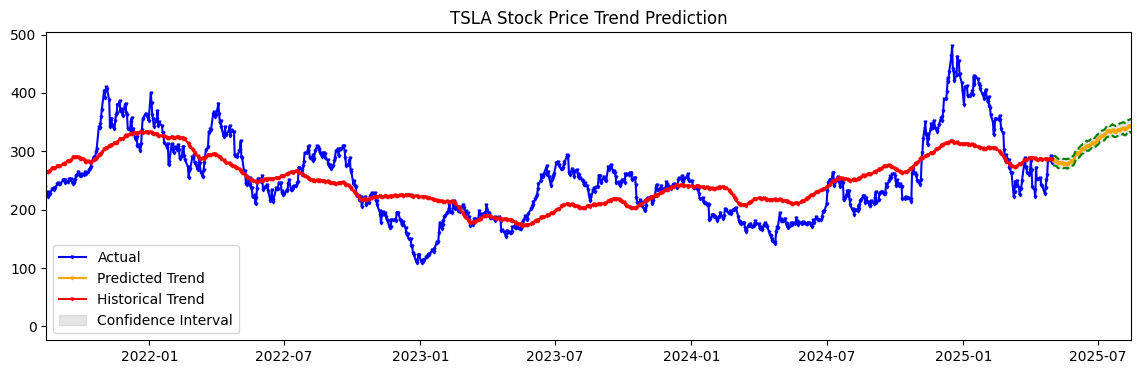

In [12]:
### PLOTTING FINAL RESULTS ###
df1 = forecast_historical.copy(deep=True)
df1.rename(columns={'yhat': 'preds'}, inplace=True)
df1 = pd.concat([df1, df_results], axis=0, ignore_index=True)
df1   = df1[df1['ds'] < real_fc_start_dt].copy(deep=True)

fig, ax = plt.subplots(figsize=(14, 4))
plt.plot(df['ds'],         df['y'],             label='Actual',           color='blue', marker='v', markersize=2)
plt.plot(df_results['ds'], df_results['preds'], label='Predicted Trend',  color='orange', marker='v', markersize=2)
plt.plot(df1['ds'],        df1['preds'],        label='Historical Trend', color='red', marker='v', markersize=2)
# Plot preds_upper and preds_lower
plt.plot(df_results['ds'], df_results['preds_upper'], color='green', linestyle='--')
plt.plot(df_results['ds'], df_results['preds_lower'], color='green', linestyle='--')

# Shade the region between preds_upper and preds_lower
plt.fill_between(df_results['ds'], df_results['preds_upper'], df_results['preds_lower'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title(f'{stock_sticker} Stock Price Trend Prediction')
plt.legend()
plt.xlim(pd.to_datetime(real_fc_end_dt) - relativedelta(years=4), pd.to_datetime(real_fc_end_dt))
# plt.ylim([150, 450])

# Save the plot
# fig.savefig(f'./figures/past_predictions/{stock_sticker}_predictions_on_04_29_2025.png', dpi=300, bbox_inches='tight')